# Building an End-to-End Web Application Integrated with Microsoft's Semantic Kernel and a Large Language Model

## Notebook \#2: Building an AI-powered Client Insight Tool

Scenario: You are a data scientist working at a large Canadian bank, and you have been asked to make a tool for advisors. The stakeholders have heard about large language models and want to create a natural language interface to a client database that will allow the advisors to pose plain English questions and get appropriately formatted responses.

In this notebook, we will walk through how to use MS Semantic Kernel to build the functionality we need for this tool. 

**Requirements:**
- python >= 3.8
  - semantic_kernel (pip installable!)
  - pandas
- An OpenAI API key (all new users have free credits to use in their first 3 months)

## Imports

In [1]:
# Semantic Kernel
import semantic_kernel as sk
from semantic_kernel.connectors.ai.open_ai import OpenAITextCompletion, OpenAIChatCompletion
from semantic_kernel.utils.settings import openai_settings_from_dot_env

import asyncio
import json

# Manipulating datasets
import pandas as pd

# Visualization (optional)
import matplotlib.pyplot as plt
import seaborn as sns

## Our (mock) dataset

The sample dataset is found in the `data` directory of the workshop repo. It contains 500 mock profiles, generated largely by ChatGPT. The fields are not entirely self consistent but resemble real data. For example, the generated postal codes may not fall exactly in the city listed and the street addresses may not exist in the city listed.

In [2]:
# Loading the data and taking a look at the first 5 rows
data = pd.read_csv("./data/sample_data_new.csv")
data.head()

,ID,name,gender,age,company_name,years_at_current_company,n_previous_jobs,net_worth,postal_code,city,province,street,person_2,relationship
0,0,Michael Wilson,M,55,TD,1.252055,1,1.000000e+04,K4M 1B4,Manotick,ON,3260 49th Ave,Tariq Wilson,Parent
1,1,Gabrielle Langdon,F,66,Light Up The World (LUTW),0.580822,2,2.655604e+06,N5W 3R4,London,ON,1188 Georgia St W,Luiza Costa,Spouse
2,2,Adnan Murphy,M,30,Glacier,0.665753,3,9.793099e+06,J0R 1B0,Saint-Adolphe-d'Howard,QC,7787 Keele St,Amelia Murphy,Grandchild
3,3,Mia Murphy,F,53,Sprout App,0.336986,4,6.841534e+05,T9V 1K6,Lloydminster,AB,1419 Victoria Park Ave,Molly Poole,Spouse
4,4,Ian Dickens,M,52,College Pro,0.668493,5,1.007084e+07,V7G 1H6,North Vancouver,BC,4438 Rue Wellington,Luca Marchetti,Sibling


Text(0.5, 0, 'Age')

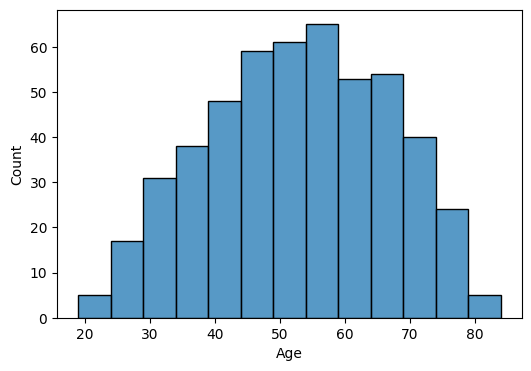

In [3]:
# Age distribution: mainly middle-aged but includes some younger and older adults
fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(x=data['age'])

ax.set_xlabel("Age")

Text(0.5, 0, 'Net worth (CAD)')

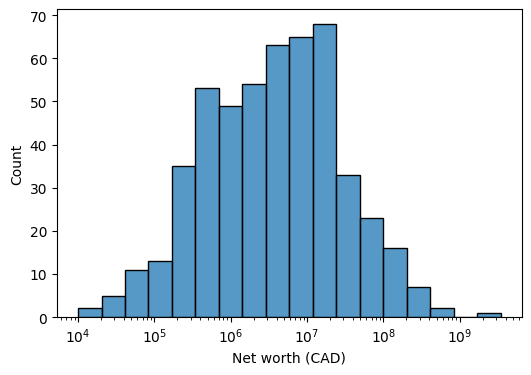

In [4]:
# Net worth distribution: ranges from $10,000 to over $1 billion CAD
fig, ax = plt.subplots(figsize=(6,4))

ax.set_xscale("log")
sns.histplot(x=data['net_worth'])

ax.set_xlabel("Net worth (CAD)")

Text(0.5, 0, 'Relationships')

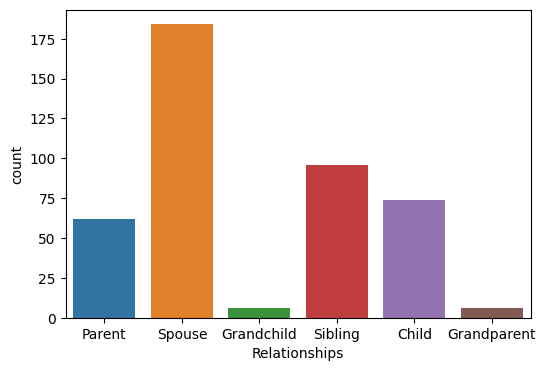

In [5]:
# Relationships distribution

fig, ax = plt.subplots(figsize=(6,4))

sns.countplot(x=data['relationship'])

ax.set_xlabel("Relationships")

## Initializing the kernel

In [6]:
kernel = sk.Kernel()

In [7]:
# You should edit the example .env file with your own OpenAI API key
api_key, org_id = openai_settings_from_dot_env()

### Configuring OpenAI backend

In [8]:
## 2 cents per 1000 tokens (prompts and responses)
#kernel.add_text_completion_service(
#    "text-davinci-003", OpenAITextCompletion("text-davinci-003", api_key, org_id)
#)

In [9]:
# 0.2 cents per 1000 tokens (prompts and responses)
kernel.add_chat_service(
    "gpt-3.5-turbo", OpenAIChatCompletion("gpt-3.5-turbo", api_key, org_id)
)

## Loading our custom skills

Based on the data available and through consultation with stakeholders, your team has identified a bare-minimum list of usage patterns that the client insight tool would need:
- Summarize information available on a specific person
- Return a list of people based on search criteria
    - Name
    - Company name
    - Location (postal code, city, or province)
    - Net worth

This will require a combination of semantic and native skills. These skills are already defined in the `skills` directory of the workshop repo. Below, we will load in each skill and demonstrate all of its functions. 

In [10]:
skills_directory = "./skills"

### Profile Summary skill

A skill is needed to write a summary of a matching profile as a short paragraph.

In [11]:
profile_skill = kernel.import_semantic_skill_from_directory(skills_directory, "ProfileSkill")

In [12]:
# Grabbing one row of data at random and converting to a JSON string
example_json_1 = data.sample(1).to_json(orient='records')

In [13]:
print(example_json_1)

[{"ID":302,"name":"Sania Li","gender":"F","age":38,"company_name":"Microsoft Business Solutions","years_at_current_company":4.002739726,"n_previous_jobs":2,"net_worth":4687295.7060000002,"postal_code":"L6P 3P3","city":"Brampton","province":"ON","street":"7 Charles St W","person_2":"Abigail Li","relationship":"Spouse"}]


In [14]:
# Asking the model to generate a summary of the example profile
output = profile_skill['Summary'](example_json_1).result
print(output)

Sania Li is a 38-year-old female who works at Microsoft Business Solutions. She has worked there for 4 years and had 2 previous jobs before her current position. Her estimated net worth is $4,687,295. She lives in Brampton, ON at 7 Charles Street West (L6P 3P3). Abigail Li is known to be her spouse.


### Filter skill

Given a JSON string with a list of profiles, return the subset of profiles matching search criteria. This is best done as a native skill because numbers and simple string comparisons are involved. 

Possible search criteria:
- Net worth
- Name
- Company name
- Location

The pandas library is used for filtering inside the individual native functions. JSON is still necessary as a robust string format for input and output due to the restrictions of SK. 

In [15]:
# Similar to importing semantic skills: "FilterSkill" is the name of a directory containing "native_function.py"
filter_skill = kernel.import_native_skill_from_directory(skills_directory, "FilterSkill")

In [16]:
# Testing filtering on net worth
context_variables = sk.ContextVariables(variables={
    "upper_limit": 50000,
    "lower_limit": 0
})

output = filter_skill["filterNetWorth"].invoke(input=data.to_json(orient='records'), variables=context_variables).result
pd.read_json(output)

,ID,name,gender,age,company_name,years_at_current_company,n_previous_jobs,net_worth,postal_code,city,province,street,person_2,relationship
0,0,Michael Wilson,M,55,TD,1.252055,1,10000.00000,K4M 1B4,Manotick,ON,3260 49th Ave,Tariq Wilson,Parent
1,83,Karen Mackenzie,F,37,Microsoft,4.583562,6,20828.64517,H3C 3P8,Montréal,QC,1600 Major Mackenzie Dr W,Emma Johnson,Spouse
2,96,Lauren Poole,F,60,"RedWorks, Inc.",0.583562,1,42687.62981,N1T 1T6,Guelph,ON,1792 Boulevard Talbot,Molly Poole,Spouse
3,110,Alexander Ibrahim,M,42,United Utilities,1.915068,5,20662.89945,L6S 4S7,Brampton,ON,369 Glebeholme Blvd,Ebrahim Ibrahim,Child
4,237,Oliver Ibrahim,M,34,SWENSON,0.252055,2,45444.18400,M3A 3N6,North York,ON,393 King St W,Manon Pelletier,Child
5,304,Naima Campbell,F,35,Thomsons Online Benefits,5.252055,4,16392.79563,L4K 4T2,Concord,ON,4700 Keele St,None,None
6,307,Kimberly Scott,F,70,"Channel Crossings, s.r.o.",1.167123,2,34699.88331,V5Y 0E8,Vancouver,BC,261 Richmond St W,Nadeem Das,Parent
7,313,Alessandro Russo,M,28,Toastmasters International,0.583562,2,28081.69665,L9B 2H6,Hamilton,ON,53 McCaul St,None,None
8,377,Ji-hoon Tremblay,M,65,Taranis Software Pty Ltd,1.252055,2,29106.00107,V1Y 1S6,Kelowna,BC,35 Balmuto St,Khaled Tremblay,Spouse
9,476,Elodie Lavoie,F,58,Cardinal Health,0.167123,4,49854.57760,M5R 1J1,Toronto,ON,25 Telegram Mews,Mia Lavoie,Spouse


In [17]:
# Testing filtering on name
context_variables = sk.ContextVariables(variables={
    "search_name": "Silva"
})

output = filter_skill["filterName"].invoke(input=data.to_json(orient='records'), variables=context_variables).result
pd.read_json(output)

/mnt/c/Workspace/SK/orlando-hackathon/backend/skills/FilterSkill/native_function.py:37: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  data_filtered = data.loc[data.name.str.contains(r"(^|\s|\-){}($|\s|\-)".format(context['search_name']), regex=True, case=False)]


,ID,name,gender,age,company_name,years_at_current_company,n_previous_jobs,net_worth,postal_code,city,province,street,person_2,relationship
0,82,Declan Silva,M,34,Domin-8 Enterprise Solutions,3.079452,5,3.809716e+07,V5K 0A2,Vancouver,BC,20 Maud St,Valentina Silva,Sibling
1,306,Gabriela Silva,F,70,Microsoft,5.589041,1,1.536604e+06,H2Y 1W5,Montreal,QC,35 Mariner Terr,Valentina Silva,Parent
2,405,Valentina Silva,F,41,Microsoft,4.169863,3,6.240415e+06,V9R 1C1,Nanaimo,BC,357 King St W,Declan Silva,Sibling
3,445,Eimear Silva,F,42,IBM,3.835616,6,1.505355e+06,V9N 9J8,Courtenay,BC,36 Lisgar St,Hugo Beaulieu,Sibling


In [18]:
# Testing filtering on company name
context_variables = sk.ContextVariables(variables={
    "search_company": "Microsoft"
})

output = filter_skill["filterCompany"].invoke(input=data.to_json(orient='records'), variables=context_variables).result
pd.read_json(output)

,ID,name,gender,age,company_name,years_at_current_company,n_previous_jobs,net_worth,postal_code,city,province,street,person_2,relationship
0,5,James Wilson,M,74,Microsoft,0.832877,6,5.243226e+06,V1N 2Y2,Castlegar,BC,1796 Main St,Zahir Wilson,Spouse
1,11,Zahra Nguyen,F,58,Microsoft,0.832877,6,6.567891e+05,V6K 1K1,Vancouver,BC,260 Harbord St,Ava Nguyen,Parent
2,12,Dev Patel,M,77,Microsoft,3.917808,1,7.424734e+06,L1K 1T3,Oshawa,ON,3925 17 Ave SE,Emily Patel,Grandparent
3,15,Marco Ferrari,M,62,Microsoft,3.917808,1,2.381249e+06,V9P 2H3,Parksville,BC,140 Eglinton Ave E,Lorenzo Ferrari,Spouse
4,19,Yusuf Ahmed,M,65,Microsoft,2.747945,2,6.422324e+05,H9B 2K9,Pointe-Claire,QC,1645 47th St NW,William Ahmed,Spouse
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,471,Valentina Martinez,F,40,Microsoft,2.087671,1,1.022644e+06,L6R 1R1,Brampton,ON,55 Stewart St,Stewart Gill,Child
88,480,Oliver MacKenzie,M,31,Microsoft,0.252055,3,5.605898e+06,M4M 2V7,Toronto,ON,151 Dan Leckie Way,Margot Poirier,Sibling
89,486,Carolina Rodrigues,F,42,Microsoft,4.756164,5,1.359298e+07,M2J 4T1,North York,ON,120 Harrison Garden Blvd,None,None
90,490,Juliette Giroux,F,59,Microsoft,2.419178,4,3.669801e+07,M4Y 1K5,Toronto,ON,30 Canterbury Pl,Vanessa Harris,Spouse


In [19]:
# Testing filtering on address
# Note that ALL context variables must be included even if not used for search
context_variables = sk.ContextVariables(variables={
    "search_postal": "",
    "search_city": "Halifax",
    "search_province": ""
})

output = filter_skill["filterLocation"].invoke(input=data.to_json(orient='records'), variables=context_variables).result
pd.read_json(output)

,ID,name,gender,age,company_name,years_at_current_company,n_previous_jobs,net_worth,postal_code,city,province,street,person_2,relationship
0,95,Lucas Gagnon,M,64,Sybari Software,2.416438,2,2.063098e+07,B3S 1N4,Halifax,NS,1808 Wellington Ave,Akira Gagnon,Spouse
1,103,John MacLeod,M,39,Microsoft,0.164384,1,2.959068e+06,B3H 2B5,Halifax,NS,1991 Lawrence Ave E,Oliver MacLeod,Spouse
2,108,Lukasz Kowalski,M,61,Garfield Robbins International,2.917808,3,5.286971e+04,B3K 3P3,Halifax,NS,2865 Don Mills Rd,None,None
3,111,Amelia Terry,F,58,Aristocrat,2.917808,6,9.632094e+06,B3M 3Y7,Halifax,NS,2627 Portage Ave,Nasir Das,Spouse
4,121,Simon Quinn,M,55,Hays,8.841096,8,1.518186e+07,B3J 1G5,Halifax,NS,2480 Cawthra Rd,Grace Quinn,Spouse
5,127,Ravi Tremblay,M,45,Microsoft,9.512329,3,6.477992e+06,B3M 3K2,Halifax,NS,240 Carlton St,Arjun Tremblay,Child
6,131,Ethan Tremblay,M,67,Microsoft,13.010959,2,4.147691e+08,B3K 3J6,Halifax,NS,432 11 Ave SE,Benjamin Cheung,Spouse
7,143,Camille Lefebvre,F,60,EXCEED IT Services & Training,0.917808,2,9.291616e+04,B3M 1V7,Halifax,NS,1330 Danforth Ave,Clara Lefebvre,Spouse
8,148,Amara Ibrahim,F,40,Nokia,45.276712,1,1.384461e+07,B3R 2H7,Halifax,NS,340-11400 27 St SE,Rashid Ibrahim,Child
9,356,William Rodriguez,M,38,Collabera Inc.,1.000000,3,2.564378e+05,B3J 1E5,Halifax,NS,10 Bellair St,None,None


## Building a custom "planner"

When a user makes a request, our tool needs to do the following:
- Determine if the user request is appropriate/within scope
- If appropriate/within scope:
  - Determine what steps are needed to meet their request and build a plan (with arguments)
  - Execute the steps and keep track of their results
- Compose a response to write in the chat

These steps would be difficult to define with code alone because the same request could be worded many different ways. This is where the power of LLMs can help!

### Trying the BasicPlanner

In [20]:
from semantic_kernel.planning.basic_planner import BasicPlanner
planner = BasicPlanner()

In [21]:
ask = """
I want to find a list of individuals living in Thornhill, ON
"""

plan = await planner.create_plan_async(ask, kernel)

In [22]:
print(plan.generated_plan)

{
        "input": "Thornhill, ON Individuals",
        "subtasks": [
            {"function": "FilterSkill.filterLocation", "args": {"search_province": "ON", "search_city": "Thornhill"}},
            {"function": "ProfileSkill.Summary"}
        ]
    }


This plan looks reasonable! But we would want the input to be a JSON string of data, not the phrase "Individuals in Thornhill, ON". We also want to capture the intermediate output (filtered data) and display as a table to the user of our tool. The basic planner as implemented won't quite work for us. 

See below what happens if we ask the planner to execute its plan:

In [23]:
# Unable to pass context variable to the plan execution
# Would need to append JSON string of data to initial ask
# Not ideal since need to pay for full data to be processed
# Could also exceed the model memory for large datasets

#context_variables = sk.ContextVariables(variables={
#    "profile_data": data.to_json(orient='records')
#})

results = await planner.execute_plan_async(plan, kernel)
print(results)

There is no available information in this JSON object.


### Handling orchestration through code-based logic and semantic functions

At its heart, the planner is a carefully created prompt supported by code. We can create a series of semantic functions to handle the steps of responding to a user request individually, and then build out the code that contains the structure and logic needed. 

Below, we will walk through our semantic skills used to parse, interpret, and respond to a user's request.

In [24]:
# Loading our custom semantic skills
parse_intent_skill = kernel.import_semantic_skill_from_directory(skills_directory, "ParseIntentSkill")
result_skill = kernel.import_semantic_skill_from_directory(skills_directory, "ResultSkill")

In [25]:
# Step 1: Determine user intent (Search, Summarize, or Unknown)

ask = "I want to find a list of individuals living in Thornhill, ON"

output = parse_intent_skill['Intent'](ask).result
print(output)

bad_ask = "Hi! How are you?"
output = parse_intent_skill['Intent'](bad_ask).result
print(output)

Search
Unknown


In [26]:
# Step 2: For a search query, check if the search is valid 

output = parse_intent_skill['CheckValidSearch'](ask).result
print(output)

bad_ask = "Find all individuals with annual income over 200k"
output = parse_intent_skill['CheckValidSearch'](bad_ask).result
print(output)

True
False


In [27]:
# Step 3: Breaking search into required steps

output = parse_intent_skill['ParseUserSearchSteps'](ask).result
print(output)

[{"step":"filterLocation", "params":{"search_postal":"", "search_city":"Thornhill", "search_province":"ON"}}
]


In [28]:
# Step 4: Parse the steps suggested by the LLM and execute them

steps = json.loads(output)
len(steps)

input_data = data.to_json(orient='records')
for step in steps:
    print(f"Filter step: {step['step']}")
    print(f"Parameters: {step['params']}")
    
    context_variables = sk.ContextVariables(variables=step['params'])
    input_data = filter_skill[step['step']].invoke(input=input_data, variables=context_variables).result
    
pd.read_json(input_data)

Filter step: filterLocation
Parameters: {'search_postal': '', 'search_city': 'Thornhill', 'search_province': 'ON'}


,ID,name,gender,age,company_name,years_at_current_company,n_previous_jobs,net_worth,postal_code,city,province,street,person_2,relationship
0,126,Gabriel Mercier,M,56,LG CNS India,2.416438,2,1.271127e+07,L4J 7J3,Thornhill,ON,1600 Michael St,None,None
1,132,Samuel Das,M,57,NASSCOM,0.504110,1,1.155633e+07,L4J 7T4,Thornhill,ON,1540 Bloor St W,Léonie Lefebvre,Parent
2,149,Lorenzo Moretti,M,76,Microsoft,1.419178,2,6.274006e+05,L3T 7P9,Thornhill,ON,1200 37 St SW,None,None
3,224,Amélie Dubois,F,45,Abbott,1.331507,5,4.052293e+05,L4J 5C8,Thornhill,ON,224 Eglington Ave W,Rebecca Simpson,Spouse
4,248,Brigid Lopes,F,41,Concepts Systems,0.167123,1,1.657334e+06,L3T 7V8,Thornhill,ON,15 York St,Charlotte O'Connor,Sibling
5,256,Charlotte Cheung,F,46,Newcastle institute of energy and resource,0.084932,1,4.324142e+06,L3T 7N3,Thornhill,ON,1 Yonge St,Elise Rochon,Parent
6,272,Joe Knox,M,58,CDK Digital Marketing,3.498630,1,2.969263e+06,L4J 8W8,Thornhill,ON,10 Dundas St E,Harry Knox,Sibling
7,276,Gabriela Oliveira,F,54,"Expedia, Inc.",1.164384,5,9.696702e+06,L4J 7K1,Thornhill,ON,4711 Yonge St,Gabriel Oliveira,Spouse
8,292,Heather Mills,F,65,Deutsche Bank,4.002740,1,3.087199e+05,L3T 2Y5,Thornhill,ON,2885 Bayview Ave,Sebastian Ellison,Parent
9,475,Molly Poole,F,50,Craftsman Book Company,6.504110,3,6.722642e+05,L3T 7V8,Thornhill,ON,25 Maitland St,Mia Murphy,Spouse


In [29]:
# Step 5: Writing a response back to the user
# Note that we provide context to the model summarizing the previous steps taken
# so that it can give a response relevant to the results

context = kernel.create_new_context()
context["ask"] = ask
context["response_context"] = """Valid request: True
Valid search: True
Rows returned: 12"""

output = result_skill['ResultResponse'](context=context)

print(output)

Great news! I was able to find a list of 12 individuals living in Thornhill, ON. Please see the attached results for more information.


### Putting it all together

In [30]:
def respond_to_request(ask, data, debug=False):
    
    response_context_str = "Valid request: "
    filtered_data = ""
    
    parse_intent_skill = kernel.import_semantic_skill_from_directory(skills_directory, "ParseIntentSkill")
    result_skill = kernel.import_semantic_skill_from_directory(skills_directory, "ResultSkill")
    
    # Interpreting user intent
    intent = parse_intent_skill['Intent'](ask).result
    if intent == "Unknown":
        response_context_str += "False"
    else:
        response_context_str += "True"

    if debug:
        print("DEBUG LOG: Intent = " + intent)
     
    # Attempting to do a search if needed
    if intent in ["Search", "Summarize"]:
        is_valid = parse_intent_skill['CheckValidSearch'](ask).result
        response_context_str += "\nValid search: " + is_valid
        
        if is_valid == "True":
            search_plan = parse_intent_skill['ParseUserSearchSteps'](ask).result  
            if debug:
                print("DEBUG LOG: Search steps = " + search_plan)
            search_steps = json.loads(search_plan)
            
            filtered_data = data.to_json(orient='records')
            for step in search_steps:
                context_variables = sk.ContextVariables(variables=step['params'])
                filtered_data = filter_skill[step['step']].invoke(input=filtered_data, variables=context_variables).result
                
            # Adding number of rows found to response context string
            response_context_str += "\nRows returned: " + str(len(pd.read_json(filtered_data)))
            
    # Done search attempt
    
    # Preparing a summary if needed
    summary_text = ""
    if intent == "Summarize":
        summary_text = profile_skill['Summary'](str(filtered_data)).result
        
    
    context = kernel.create_new_context()
    context["ask"] = ask
    context["response_context"] = response_context_str
    
    if debug:
        print("DEBUG LOG: \n" + response_context_str)

    final_response = result_skill['ResultResponse'](context=context).result
    print(final_response)
    
    # Displaying results (if there are any to display)
    if len(summary_text) > 0:
        print(summary_text)
        
    elif len(filtered_data) > 0:
        # Display table of output
        print(pd.read_json(filtered_data))
    

In [31]:
respond_to_request("Find people with the last name Ibrahim with net worth over $1 MM", data)

/mnt/c/Workspace/SK/orlando-hackathon/backend/skills/FilterSkill/native_function.py:37: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  data_filtered = data.loc[data.name.str.contains(r"(^|\s|\-){}($|\s|\-)".format(context['search_name']), regex=True, case=False)]


Great news! I was able to find 6 individuals with the last name Ibrahim and a net worth over $1 million. Here are the details:
    ID               name gender  age                            company_name  \
0   78    Mustafa Ibrahim      M   41                                     IBM   
1  148      Amara Ibrahim      F   40                                   Nokia   
2  156  Charlotte Ibrahim      F   60                               Microsoft   
3  160      Rahim Ibrahim      M   57  Sunera Technologies, Inc. (SuneraTech)   
4  227     Darius Ibrahim      M   76                       Boston Scientific   
5  448      James Ibrahim      M   54                            Hanbit Media   

   years_at_current_company  n_previous_jobs     net_worth postal_code  \
0                  2.835616                1  1.701349e+07     V5R 6J9   
1                 45.276712                1  1.384461e+07     B3R 2H7   
2                  0.252055                3  3.594232e+06     A2H 2Y3   
3        

In [32]:
respond_to_request("Hi! Can you recommend a recipe using cilantro?", data)

I'm sorry, but this tool is designed for client insight in the banking industry and is not able to provide recipe recommendations.


In [33]:
respond_to_request("I'd like to find individuals in Vancouver with net worth between 500k and 2.5 million", data)

Thank you for using our client insight tool. I was able to find 10 individuals in Vancouver with net worth between 500k and 2.5 million. Please see the attached report for more details. Let us know if you have any further questions or requests.
    ID              name gender  age                      company_name  \
0   11      Zahra Nguyen      F   58                         Microsoft   
1   65    Zaynab Leblanc      F   43                        GE Capital   
2   73     Jérémie Caron      M   50        Intandem Solutions Limited   
3   77      Helena Alves      F   65        Intandem Solutions Limited   
4   80   Christopher Lee      M   57                          Deloitte   
5  317  Isabella Leblanc      F   37                              bwin   
6  412     Aasiyah Patel      F   38                               CEA   
7  431        Liam Patel      M   84                               IBM   
8  437    Samantha Mills      F   43  Registro civil Torrejon de Ardoz   
9  450      Ami

In [35]:
respond_to_request("Tell me about Matteo Leblanc", data)

/mnt/c/Workspace/SK/orlando-hackathon/backend/skills/FilterSkill/native_function.py:37: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  data_filtered = data.loc[data.name.str.contains(r"(^|\s|\-){}($|\s|\-)".format(context['search_name']), regex=True, case=False)]


I'm sorry, I could not find any information on Matteo Leblanc in our database.
There is no information available in this JSON object.


We've accomplished the minimum functionality needed for our tool! Next, we will talk about how to transform this into a web application. 

Possible improvements to our minimum functionality:
- More search options (age, relationships)
- Interpretation of search terms (e.g. "Find clients in the GTA" --> search in Toronto, Missisauga, Etobicoke, North York, ...)
- Use chat-style history instead of each request being separate